# Questioning the Effect of Physiological Heartbeat Synchrony in Romantic Dyads. A Preregistered Deep Learning Analysis.

### For Google Colab only:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Masterarbeit/Code/two-hearts/')

## Deep Learning

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import array, hstack
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from lists import list_str

tf.version.VERSION

'2.3.0'

In [7]:
# Load data
data = np.load("data/data_gaze.npy")
    # data[i] = np.load(datafiles_google[i]) # for google colab

# Data preperation for keras
print(data.dtype)
print(data.shape)

float32
(4, 14800)


In [3]:
# Setting sampling rate
sampling_rate = 50
print("Sampling rate:", sampling_rate)

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # to remove redundancy in ECG data ## maybe only use a fraction of sampling_rate to just reduce the redundancy
        if i % (sampling_rate) == 0:
            # find the end of this pattern
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out
            # check if we are beyond the dataset
            if out_end_ix > len(sequences):
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
            X.append(seq_x)
            y.append(seq_y)
    return array(X), array(y)

Sampling rate: 50


num_train_samples: 144
num_val_samples: 72
num_test_samples: 72
num_train_samples: 144
num_val_samples: 72
num_test_samples: 72
288 144 144


(144, 150, 2)

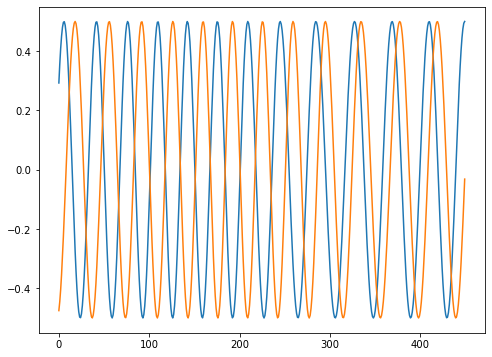

In [8]:
# choose a number of time steps
n_steps_in, n_steps_out = 6*sampling_rate, 3*sampling_rate

X_train = np.empty((0, n_steps_in, 2))
X_vali = np.empty((0, n_steps_in, 2))
X_test = np.empty((0, n_steps_in, 2))
y_train = np.empty((0, n_steps_out, 2))
y_vali = np.empty((0, n_steps_out, 2))
y_test = np.empty((0, n_steps_out, 2))


idx = list(range(len(list_str)))[::2] # for dyads

for i in range(len(idx)):
        # define input sequence
        in_seq1 = data[idx[i]]
        in_seq2 = data[idx[i]+1]
        # convert to [rows, columns] structure
        in_seq1 = in_seq1.reshape((len(in_seq1), 1))
        in_seq2 = in_seq2.reshape((len(in_seq2), 1))
        # horizontally stack columns
        dataset = hstack((in_seq1, in_seq2))

        # covert into input/output
        X, y = split_sequences(dataset, n_steps_in, n_steps_out)

        # Data split
        num_train_samples = int(0.5 * len(X))
        num_val_samples = int(0.25 * len(X))
        num_test_samples = len(X) - num_train_samples - num_val_samples
        print("num_train_samples:", num_train_samples)
        print("num_val_samples:", num_val_samples)
        print("num_test_samples:", num_test_samples)

        X_train = np.append(X_train,X[:num_train_samples],axis=0)
        y_train = np.append(y_train,y[:num_train_samples],axis=0)
        X_vali = np.append(X_vali,X[num_train_samples:(num_train_samples+num_val_samples)],axis=0)
        y_vali = np.append(y_vali,y[num_train_samples:(num_train_samples+num_val_samples)],axis=0)
        X_test = np.append(X_test,X[(num_train_samples+num_val_samples):],axis=0)
        y_test = np.append(y_test,y[(num_train_samples+num_val_samples):],axis=0)

n_features = X.shape[2]

test = np.append(X[3,:,0], y[3,:,0])
test2 = np.append(X[2,:,0], y[2,:,0])
plt.plot(test)
plt.plot(test2)
print(len(X_train), len(X_vali), len(X_test))

In [9]:
# define model
# Model from Brownlee 2018 - Deep Learning for Time Series Forecasting

model = Sequential()
model.add(LSTM(300, activation='relu', input_shape=(n_steps_in, n_features), return_sequences=False))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(150, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

model.compile(keras.optimizers.Adam(learning_rate=0.001,clipvalue=0.5), loss='mse', metrics=["mae"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               363600    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 150, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 150)          270600    
_________________________________________________________________
time_distributed (TimeDistri (None, 150, 2)            302       
Total params: 634,502
Trainable params: 634,502
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# fit model
history = model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=1, validation_data=(X_vali, y_vali))

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
mae = history_dict["mae"]
val_mae = history_dict["val_mae"]
plt.plot(epochs, mae, "bo", label="Training mae")
plt.plot(epochs, val_mae, "b", label="Validation mae")
plt.title("Training and validation mean absolute error")
plt.xlabel("Epochs")
plt.ylabel("Mean absolute error")
plt.legend()
plt.show()

In [ ]:
yhat_train = model.predict(X_train,batch_size=10)
yhat_test = model.predict(X_test,batch_size=10)

In [ ]:
# model demonstration
trial = 15
person = 1

# demonstrate training

train = np.append(X_train[trial,:,person],yhat_train[trial,:,person])
train2 = np.append(X_train[trial,:,person],y_train[trial,:,person])

fig = plt.figure(figsize=(8,4), dpi=96)
plt.figure(1)
plt.plot(train)
plt.plot(train2)

# demonstrate prediction

test = np.append(X_test[trial,:,person],yhat_test[trial,:,person])
test2 = np.append(X_test[trial,:,person],y_test[trial,:,person])

fig = plt.figure(figsize=(8,4), dpi=96)
plt.figure(2)

# plt.plot(test)
# plt.plot(test2)
plt.plot(X_train[trial,:,person])
plt.plot(X_train[trial,:,person])
plt.plot(yhat_train[trial,:,person])